# Bonus: ParmEst with Two Datasets

We have already estimated the four parameters ($U_a$, $U_b$, $C_p^H$, $C_p^S$) in the TCLab model using the [step test data](../notebooks/parmest_exercise.ipynb) and [sine test data](../notebooks/parmest.ipynb).

Can we use ParmEst to estimate these parameters using both data sets simultanously? Yes, we can! Let's see the syntax below.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
)

## Load and explore experimental data (step test)

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df_step = pd.read_csv(file)
df_step.head()

Time     T1     T2    Q1   Q2
0  0.00  22.84  22.52  50.0  0.0
1  1.01  22.84  22.52  50.0  0.0
2  2.01  22.84  22.52  50.0  0.0
3  3.00  22.84  22.52  50.0  0.0
4  4.00  22.84  22.20  50.0  0.0

Make two plots to visualize the temperature and heat power data as a function of time.

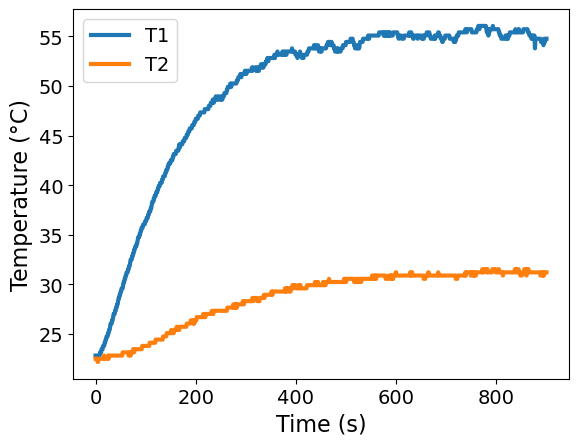

In [3]:
ax = df_step.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')


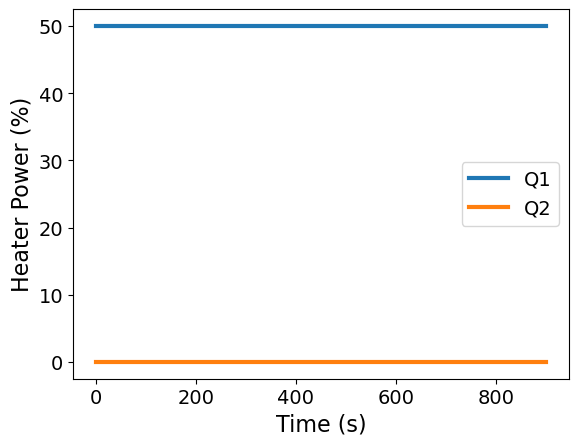

In [4]:
ax = df_step.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

We'll now store the data in this custom *data class* objective. This is a nice trick to help keep data organized, but it is NOT required to use ParmEst or Pyomo data. Alternatively, we could just use a pandas DataFrame.

In [5]:
def df_to_dataclass(df):
    tc_data = TCLabExperiment(
        name="Sine Wave Test for Heater 1",
        time=df['Time'].values,
        T1=df['T1'].values,
        u1=df['Q1'].values,
        P1=200,
        TS1_data=None,
        T2=df['T2'].values,
        u2=df['Q2'].values,
        P2=200,
        TS2_data=None,
        Tamb=df['T1'].values[0],
    )
    return tc_data

tc_data_step = df_to_dataclass(df_step)

Our custom data class has a method to export the data as a Pandas Data Frame.

In [6]:
tc_data_step.to_data_frame().head()

time     T1    u1   P1 TS1_data     T2   u2   P2 TS2_data   Tamb
0  0.00  22.84  50.0  200     None  22.52  0.0  200     None  22.84
1  1.01  22.84  50.0  200     None  22.52  0.0  200     None  22.84
2  2.01  22.84  50.0  200     None  22.52  0.0  200     None  22.84
3  3.00  22.84  50.0  200     None  22.52  0.0  200     None  22.84
4  4.00  22.84  50.0  200     None  22.20  0.0  200     None  22.84

## Load and explore experimental data (sine test)

In [7]:
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df_sine = pd.read_csv(file)
df_sine.head()

Time     T1     T2    Q1   Q2
0  0.00  24.45  24.13  50.0  0.0
1  1.00  24.45  24.13  55.0  0.0
2  2.01  24.45  24.13  60.0  0.0
3  3.01  24.45  24.13  65.0  0.0
4  4.01  24.77  23.81  70.0  0.0

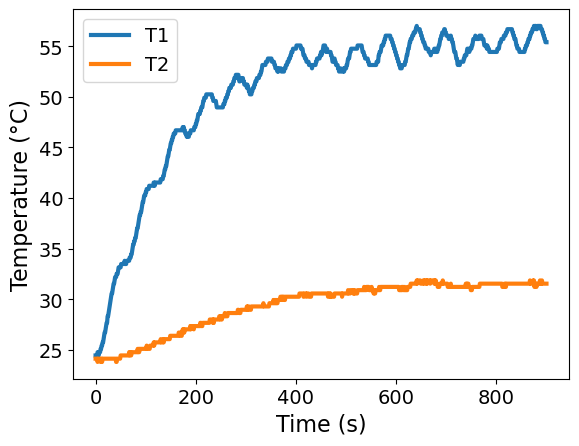

In [8]:
ax = df_sine.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')


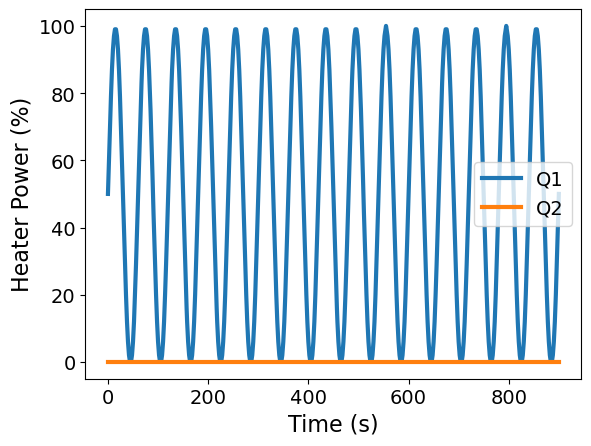

In [9]:
ax = df_sine.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [10]:
tc_data_sine = df_to_dataclass(df_sine)

## Parameter estimation with ParmEst

Now for the main event: performing nonlinear least squares with `ParmEst`. For multiple datasets, we just need to give `ParmEst` a list of dictionaries or pandas dataframes where each entry is an experiment. It's that easy.



In [11]:
# Call ParmEst
import pyomo.contrib.parmest.parmest as parmest

parmest_create_model = lambda data: create_model(
    data=data, mode='parmest', number_of_states=2
)

# define the parameter names as a list
# two-state model
theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']

# four-state model
# theta_names = ['Ua', 'Ub', 'Uc','inv_CpH', 'inv_CpS']

data_in_list = [tc_data_step.to_data_frame(), tc_data_sine.to_data_frame()]

# Create a parameter estimation object
pest = parmest.Estimator(
    parmest_create_model,
    data=data_in_list,
    theta_names=theta_names,
    tee=True,
)

obj, theta = pest.theta_est()

(model_function, data, theta_names). This interface will be removed in a
future release, please update to the new parmest interface using experiment
lists.  (deprecated in 6.7.2) (called from
/Users/adowling/opt/anaconda3/envs/summer2024/lib/python3.10/functools.py:926)
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientif

In [12]:
print("Estimated parameters:")
print(theta)

Estimated parameters:
Ua          0.050244
Ub          0.000500
inv_CpH     0.146888
inv_CpS    99.999995
dtype: float64


**Discussion**: How do these results compare to our [previous analysis](../notebooks/parmest.ipynb)?

In progress: modifying our helper functions in `tclab_pyomo.py` to extract and plot results from a ParmEst model with multiple datasets.